In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
# 设置matplotlib正常显示中文和负号
plt.rcParams['font.sans-serif']=['SimHei']   # 用黑体显示中文
plt.rcParams['axes.unicode_minus']=False     # 正常显示负号

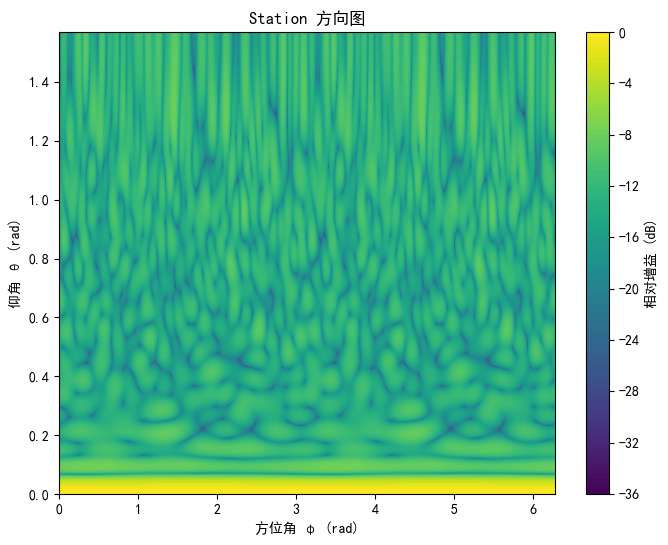

In [2]:
# 生成随机天线位置
def generate_antenna_positions(num_antennas, diameter, min_distance):
    positions = []
    while len(positions) < num_antennas:
        x = np.random.uniform(-diameter/2, diameter/2)
        y = np.random.uniform(-diameter/2, diameter/2)
        if np.sqrt(x**2 + y**2) <= diameter/2:
            new_position = np.array([x, y])
            if all(np.linalg.norm(new_position - np.array(pos)) >= min_distance for pos in positions):
                positions.append(new_position)
    return np.array(positions)

# 计算方向图
def compute_beam_pattern(positions, grid_size=360,fre= 150e6):
    theta = np.linspace(0, np.pi/2, grid_size)
    phi = np.linspace(0, 2*np.pi, grid_size)
    theta_grid, phi_grid = np.meshgrid(theta, phi)
    
    lamda = 3.0e8/fre
    k = 2 * np.pi/lamda  # 波数
    beam_pattern = np.zeros_like(theta_grid, dtype=complex)
    
    for pos in positions:
        r = pos[0] * np.sin(theta_grid) * np.cos(phi_grid) + pos[1] * np.sin(theta_grid) * np.sin(phi_grid)
        beam_pattern += np.exp(1j * k * r)
    
    beam_pattern = np.abs(beam_pattern)
    beam_pattern /= np.max(beam_pattern)
    
    return theta_grid, phi_grid, beam_pattern

# 保存FITS文件
def save_to_fits(data, filename='beam_pattern_11.fits'):
    hdu = fits.PrimaryHDU(data)
    
    # 添加FITS头信息
    hdu.header['OBJECT'] = 'Station Beam Pattern'
    hdu.header['CTYPE1'] = 'AZ'  # 方位角
    hdu.header['CTYPE2'] = 'ZA'  # 天顶角
    hdu.header['CRVAL1'] = 0
    hdu.header['CRVAL2'] = 0
    hdu.header['CDELT1'] = 360 / data.shape[1]  # 每个像素的方位角度数
    hdu.header['CDELT2'] = 90 / data.shape[0]   # 每个像素的天顶角度数
    hdu.header['CRPIX1'] = data.shape[1] // 2
    hdu.header['CRPIX2'] = data.shape[0] // 2
    hdu.header['CUNIT1'] = 'deg'
    hdu.header['CUNIT2'] = 'deg'
    
    hdulist = fits.HDUList([hdu])
    hdulist.writeto(filename, overwrite=True)

num_antennas = 256
diameter = 35
min_distance = 1

positions = generate_antenna_positions(num_antennas, diameter, min_distance)

theta_grid, phi_grid, beam_pattern = compute_beam_pattern(positions)

# 将方向图保存为FITS文件
save_to_fits(beam_pattern)

# 绘制方向图
plt.figure(figsize=(8, 6))
plt.contourf(phi_grid, theta_grid, 10 * np.log10(beam_pattern), levels=100, cmap='viridis')
plt.colorbar(label='相对增益 (dB)')
plt.xlabel('方位角 φ (rad)')
plt.ylabel('仰角 θ (rad)')
plt.title('Station 方向图')
plt.show()


C:\Users\honor\AppData\Local\Temp\ipykernel_33804\2372729217.py:21: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(10 * np.log10(image), extent=[-1, 1, -1, 1], origin='lower', cmap='inferno')


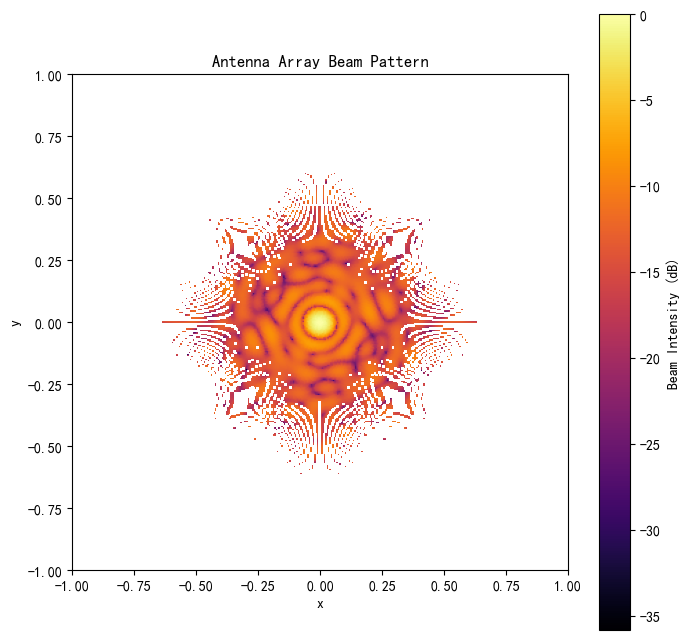

In [3]:
# 将theta和phi转换为fits图像的坐标（球坐标）
x_fits = (np.sin(theta_grid) * np.cos(phi_grid)).flatten()
y_fits = (np.sin(theta_grid) * np.sin(phi_grid)).flatten()
z_fits = np.cos(theta_grid).flatten()

# 创建空的图像并填充
resolution = 360
image = np.zeros((resolution, resolution))
for i in range(len(x_fits)):
    x_idx = int((x_fits[i] + 1) / 2 * (resolution - 1))
    y_idx = int((y_fits[i] + 1) / 2 * (resolution - 1))
    image[x_idx, y_idx] = beam_pattern.flatten()[i]

# 保存为FITS文件
hdu = fits.PrimaryHDU(image)
hdul = fits.HDUList([hdu])
hdul.writeto('beam_pattern111.fits', overwrite=True)

# 可视化方向图
plt.figure(figsize=(8, 8))
plt.imshow(10 * np.log10(image), extent=[-1, 1, -1, 1], origin='lower', cmap='inferno')
plt.colorbar(label='Beam Intensity (dB)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Antenna Array Beam Pattern')
plt.show()

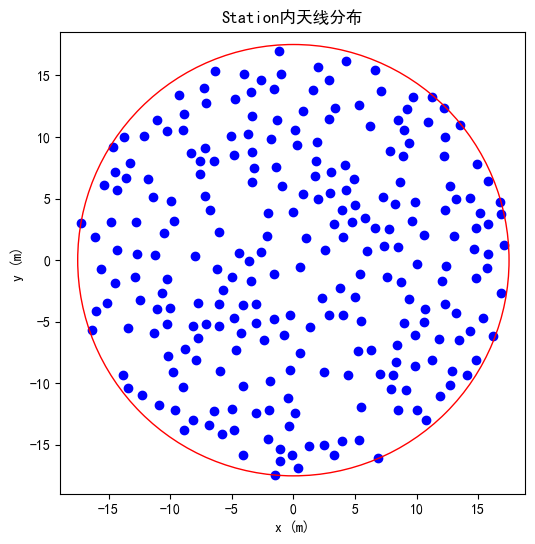

In [4]:
# 绘制station中天线的分布
plt.figure(figsize=(6, 6))
plt.scatter(positions[:,0], positions[:,1], color='b')
circle = plt.Circle((0, 0), diameter/2, color='r', fill=False)
plt.gca().add_artist(circle)
plt.gca().set_aspect('equal', adjustable='datalim')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Station内天线分布')
plt.show()